In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn import preprocessing

import change_detection

## Data setup

### 1. Data import

In [3]:
def check_sampling(df_1: pd.DataFrame, df_2: pd.DataFrame) -> bool:
    """_summary_

    Args:
        df_1 (pd.DataFrame): _description_
        df_2 (pd.DataFrame): _description_

    Returns:
        bool: _description_
    """
    timedelta_1 = list(pd.Series(df_1.index).shift(-1) - pd.Series(df_1.index))[0]
    timedelta_2 = list(pd.Series(df_2.index).shift(-1) - pd.Series(df_2.index))[0]

    # If sampling of the first dataframe is sparser return true
    if timedelta_1 < timedelta_2: return True
    # Else false
    return False

In [4]:
def preprocess_csv(csv_path, date_column,  delimiter=',', freq='5min', int_method='linear'):
    """_summary_

    Args:
        csv_path (_type_): _description_
        date_column (_type_): _description_
        delimiter (str, optional): _description_. Defaults to ','.
        freq (str, optional): _description_. Defaults to '5min'.
        int_method (str, optional): _description_. Defaults to 'linear'.

    Returns:
        _type_: _description_
    """


    # Read csv
    df = pd.read_csv(csv_path, delimiter=delimiter)
    date_format = '%d/%m/%Y %H:%M:%S'
        

    # Format the original df
    df.index = pd.to_datetime(df[date_column], format=date_format)
    date_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq=freq)
    df.drop(columns=date_column, inplace=True)

    # Format the new df
    df_new = pd.DataFrame({date_column: date_index})
    df_new.index = df_new[date_column]
    df_new.drop(columns=date_column, inplace=True)

    # Check sampling
    if check_sampling(df, df_new):
        df.resample(freq).mean()

    # Fill the missing dates    
    df_full = df.merge(df_new, how='right', left_index=True, right_index=True)
    df_full = df_full.interpolate(method=int_method)

    X = df_full.values

    # Scale the data
    scaler = preprocessing.StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return pd.DataFrame(data=X_scaled, columns=df_full.columns, index=date_index)

In [5]:
df = preprocess_csv('data\Output_cigre_B1.csv', 'date', freq='15min')

### 2. Functions

In [6]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size//2:]

In [7]:
def standardize(x):
    return (x - np.average(x)) / np.std(x)

In [8]:
def rolling_avg(x, n):
    return np.array([np.average(x[i-n//2:i+n//2]) for i in np.arange(n//2, len(x)-n//2)])

In [9]:
def diff(x):
    return np.array(x[1:]-np.roll(x, 1)[1:])

### Test

In [10]:
# It automatically remembers the state 
def x_generator(x):
    for x_i in x:
        yield x_i


In [11]:
gen = x_generator(df.errore.values)

In [12]:
INIT_FRAMES = 10
INIT_INTERVAL = [next(gen) for _ in range(INIT_FRAMES)]

In [13]:
interval = INIT_INTERVAL.copy()
interval.append(next(gen))
print(f'New interval lenght: {len(interval)}')

New interval lenght: 11


In [14]:
mean_interval = np.mean(interval)
std_n_interval = np.std(interval) / np.sqrt(len(interval))
print(f'Mean: {mean_interval}, std: {std_n_interval}')

Mean: 0.545231335040907, std: 0.06113408332119674


In [15]:
means_test = []
stds_test = []
change = []
CI = None

for i in range(100):    

    interval.append(next(gen))

    mean_interval = np.mean(interval)
    std_n_interval = np.std(interval) / np.sqrt(len(interval))

    if CI is None:
        CI = (mean_interval - 1.96*std_n_interval, mean_interval + 1.96*std_n_interval)
    
    new_min = mean_interval - 1.96*std_n_interval
    new_max = mean_interval + 1.96*std_n_interval
    old_min, old_max = CI
    if max(old_min, new_min) > min(old_max, new_max):
        change.append(i)
        CI = (new_min, new_max)
    else:
        CI = (max(old_min, new_min), min(old_max, new_max))


    means_test.append(mean_interval)
    stds_test.append(std_n_interval)

In [16]:
change # WRONG: the interval should reset

[26]

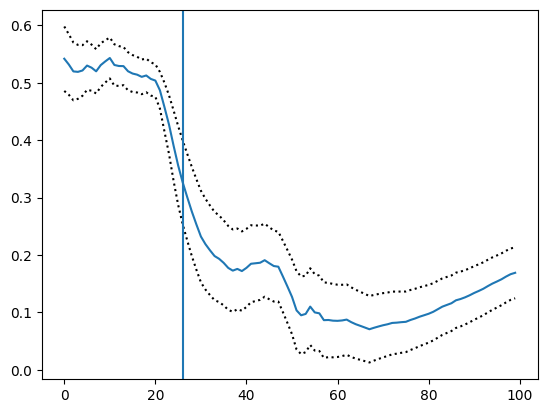

In [17]:
plt.plot(means_test)
plt.plot(np.array(means_test)-np.array(stds_test), c='k', linestyle=':')
plt.plot(np.array(means_test)+np.array(stds_test), c='k', linestyle=':')
plt.axvline(change[0])

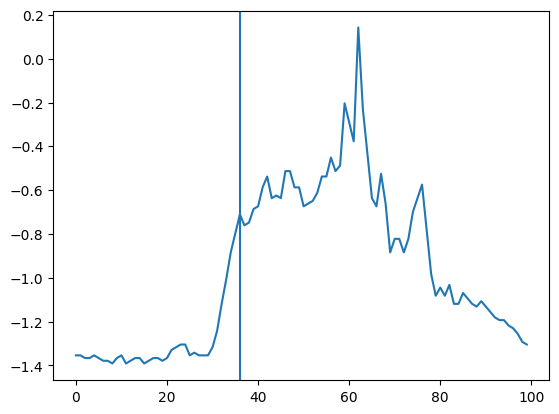

In [18]:
plt.plot(df.T_m.values[:100])
plt.axvline(change[0]+INIT_FRAMES)

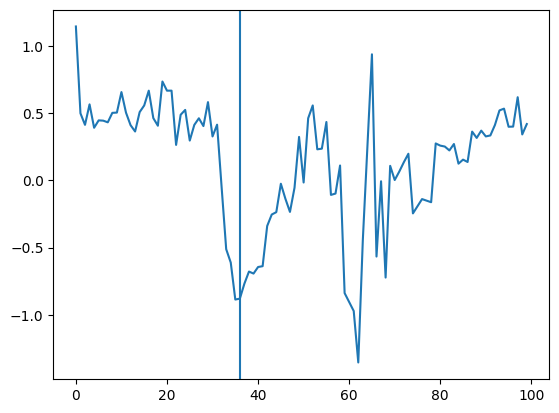

In [42]:
plt.plot(df.errore.values[:100])
plt.axvline(change[0]+INIT_FRAMES)

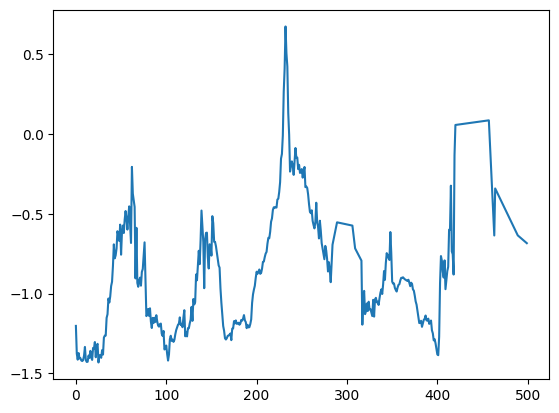

In [45]:
plt.plot(df.T_f.values[:500])